In [137]:
#SOM网络pytorch实现
import numpy as np
c1 = np.array([1,1])
c2 = np.array([-1,-1])
c3 = np.array([1,-1])
c4 = np.array([-1,1])

In [138]:
x1 = c1 + np.random.random_sample([100,2])-1
x2 = c2 + np.random.random_sample([100,2])
x3 = c3 + np.random.random_sample([100,2])-1
x4 = c4 + np.random.random_sample([100,2])-1
x3[:,1] = x3[:,1] + 1
x4[:,0] = x4[:,0] + 1

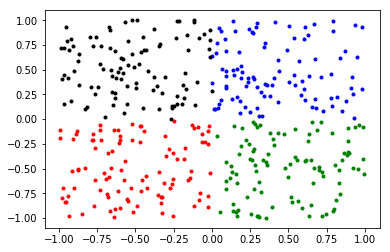

In [139]:
import matplotlib.pyplot as plt
plt.plot(x1[:,0],x1[:,1],'b.')
plt.plot(x2[:,0],x2[:,1],'r.')
plt.plot(x3[:,0],x3[:,1],'g.')
plt.plot(x4[:,0],x4[:,1],'k.')
plt.show()

In [140]:
x = np.concatenate((x1,x2,x3,x4))
label = np.concatenate((np.array([1]*100),np.array([2]*100),np.array([3]*100),np.array([4]*100)))

In [141]:
print(x.shape)
print(label.shape)

(400, 2)
(400,)


In [142]:
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(label)

In [143]:
import torch
import torch.nn as nn
x = torch.FloatTensor(x)
y = torch.tensor(label)
print(x[1])

tensor([-0.5811,  0.4649])


In [233]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [248]:
class SOM(nn.Module):
    """Model proposed in understanding beta-VAE paper(Burgess et al, arxiv:1804.03599, 2018)."""

    def __init__(self):
        super(SOM, self).__init__()
        self.SOM_layer = nn.Parameter(torch.Tensor(4, 2))
        self.weight_init()

    def weight_init(self):
        for w in self.SOM_layer:
            kaiming_init(w)
    def forward(self, x, y = None):
        distance = [(((x-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in self.SOM_layer]
        distance = torch.cat(distance,dim=-1)
        if y is None:
            _, index = distance.min(dim=1)
        else:
            index = y-1
        mask = Variable(torch.eye(4).index_select(dim=0, index=index.data))

        return mask, index

In [249]:
from torch.utils.data import Dataset, DataLoader
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, label_tensor):
        self.data_tensor = data_tensor
        self.label_tensor = label_tensor

    def __getitem__(self, index):
        return self.data_tensor[index],self.label_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)
def return_data(it):
    return x[10*(it-1):it*10,:],y[10*(it-1):it*10]

In [291]:
from tqdm import tqdm
from torch.autograd import Variable
import torch.optim as optim
net = SOM()

def train():
    optimizer = optim.Adam(net.parameters(), lr=10e-4,
                                    betas=(0.9, 0.99))
    print("training start!!!")
    global_iter = 0
    it = 1
    pbar = tqdm(total=1000)
    pbar.update(global_iter)
    for i in range(1000):
        x_,y = return_data(it)
        pbar.update(1)
        if it == 10:
            it = 1
        else:
            it += 1
        global_iter += 1
        x_ = Variable(x_)
        y = Variable(y)
        mask, index = net(x_)
        cluster_loss = (torch.cat([(((x_-w)**2).sum(-1)).unsqueeze(-1) for w in net.SOM_layer],dim=-1)*mask).sum(1).mean(0)
        optimizer.zero_grad()
        cluster_loss.backward()
        optimizer.step()
        print(cluster_loss)
    pbar.close()

In [292]:
x.shape

torch.Size([400, 2])

In [293]:
train()

training start!!!





  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

tensor(0.6953, grad_fn=<MeanBackward0>)
tensor(0.4729, grad_fn=<MeanBackward0>)
tensor(0.5899, grad_fn=<MeanBackward0>)
tensor(0.5825, grad_fn=<MeanBackward0>)
tensor(0.8157, grad_fn=<MeanBackward0>)
tensor(0.7139, grad_fn=<MeanBackward0>)
tensor(0.6628, grad_fn=<MeanBackward0>)
tensor(0.7327, grad_fn=<MeanBackward0>)
tensor(0.6580, grad_fn=<MeanBackward0>)
tensor(0.9650, grad_fn=<MeanBackward0>)
tensor(0.6827, grad_fn=<MeanBackward0>)
tensor(0.4593, grad_fn=<MeanBackward0>)
tensor(0.5801, grad_fn=<MeanBackward0>)
tensor(0.5731, grad_fn=<MeanBackward0>)
tensor(0.8023, grad_fn=<MeanBackward0>)
tensor(0.7035, grad_fn=<MeanBackward0>)
tensor(0.6502, grad_fn=<MeanBackward0>)
tensor(0.7218, grad_fn=<MeanBackward0>)
tensor(0.6467, grad_fn=<MeanBackward0>)
tensor(0.9534, grad_fn=<MeanBackward0>)
tensor(0.6698, grad_fn=<MeanBackward0>)
tensor(0.4460, grad_fn=<MeanBackward0>)
tensor(0.5692, grad_fn=<MeanBackward0>)
tensor(0.5630, grad_fn=<MeanBackward0>)
tensor(0.7888, grad_fn=<MeanBackward0>)





  3%|██▋                                                                            | 34/1000 [00:00<00:02, 339.10it/s]

tensor(0.5525, grad_fn=<MeanBackward0>)
tensor(0.7742, grad_fn=<MeanBackward0>)
tensor(0.6808, grad_fn=<MeanBackward0>)
tensor(0.6247, grad_fn=<MeanBackward0>)
tensor(0.7003, grad_fn=<MeanBackward0>)
tensor(0.6176, grad_fn=<MeanBackward0>)
tensor(0.9263, grad_fn=<MeanBackward0>)
tensor(0.6449, grad_fn=<MeanBackward0>)
tensor(0.4214, grad_fn=<MeanBackward0>)
tensor(0.5435, grad_fn=<MeanBackward0>)
tensor(0.5418, grad_fn=<MeanBackward0>)
tensor(0.7593, grad_fn=<MeanBackward0>)
tensor(0.6679, grad_fn=<MeanBackward0>)
tensor(0.6120, grad_fn=<MeanBackward0>)
tensor(0.6898, grad_fn=<MeanBackward0>)
tensor(0.6024, grad_fn=<MeanBackward0>)
tensor(0.9119, grad_fn=<MeanBackward0>)
tensor(0.6319, grad_fn=<MeanBackward0>)
tensor(0.4100, grad_fn=<MeanBackward0>)
tensor(0.5296, grad_fn=<MeanBackward0>)
tensor(0.5312, grad_fn=<MeanBackward0>)
tensor(0.7446, grad_fn=<MeanBackward0>)
tensor(0.6551, grad_fn=<MeanBackward0>)
tensor(0.5996, grad_fn=<MeanBackward0>)
tensor(0.6786, grad_fn=<MeanBackward0>)





  6%|████▉                                                                          | 63/1000 [00:00<00:02, 320.81it/s]

tensor(0.5161, grad_fn=<MeanBackward0>)
tensor(0.5208, grad_fn=<MeanBackward0>)
tensor(0.7304, grad_fn=<MeanBackward0>)
tensor(0.6422, grad_fn=<MeanBackward0>)
tensor(0.5873, grad_fn=<MeanBackward0>)
tensor(0.6661, grad_fn=<MeanBackward0>)
tensor(0.5737, grad_fn=<MeanBackward0>)
tensor(0.8817, grad_fn=<MeanBackward0>)
tensor(0.6071, grad_fn=<MeanBackward0>)
tensor(0.3895, grad_fn=<MeanBackward0>)
tensor(0.5032, grad_fn=<MeanBackward0>)
tensor(0.5100, grad_fn=<MeanBackward0>)
tensor(0.7165, grad_fn=<MeanBackward0>)
tensor(0.6294, grad_fn=<MeanBackward0>)
tensor(0.5752, grad_fn=<MeanBackward0>)
tensor(0.6539, grad_fn=<MeanBackward0>)
tensor(0.5604, grad_fn=<MeanBackward0>)
tensor(0.8666, grad_fn=<MeanBackward0>)
tensor(0.5953, grad_fn=<MeanBackward0>)
tensor(0.3802, grad_fn=<MeanBackward0>)
tensor(0.4910, grad_fn=<MeanBackward0>)
tensor(0.4995, grad_fn=<MeanBackward0>)
tensor(0.7031, grad_fn=<MeanBackward0>)
tensor(0.6170, grad_fn=<MeanBackward0>)
tensor(0.5635, grad_fn=<MeanBackward0>)





  9%|███████▍                                                                       | 94/1000 [00:00<00:02, 312.90it/s]

tensor(0.4893, grad_fn=<MeanBackward0>)
tensor(0.6901, grad_fn=<MeanBackward0>)
tensor(0.6051, grad_fn=<MeanBackward0>)
tensor(0.5522, grad_fn=<MeanBackward0>)
tensor(0.6304, grad_fn=<MeanBackward0>)
tensor(0.5356, grad_fn=<MeanBackward0>)
tensor(0.8379, grad_fn=<MeanBackward0>)
tensor(0.5723, grad_fn=<MeanBackward0>)
tensor(0.3628, grad_fn=<MeanBackward0>)
tensor(0.4670, grad_fn=<MeanBackward0>)
tensor(0.4795, grad_fn=<MeanBackward0>)
tensor(0.6775, grad_fn=<MeanBackward0>)
tensor(0.5935, grad_fn=<MeanBackward0>)
tensor(0.5413, grad_fn=<MeanBackward0>)
tensor(0.6192, grad_fn=<MeanBackward0>)
tensor(0.5240, grad_fn=<MeanBackward0>)
tensor(0.8244, grad_fn=<MeanBackward0>)
tensor(0.5613, grad_fn=<MeanBackward0>)
tensor(0.3545, grad_fn=<MeanBackward0>)
tensor(0.4557, grad_fn=<MeanBackward0>)
tensor(0.4701, grad_fn=<MeanBackward0>)
tensor(0.6653, grad_fn=<MeanBackward0>)
tensor(0.5824, grad_fn=<MeanBackward0>)
tensor(0.5308, grad_fn=<MeanBackward0>)
tensor(0.6084, grad_fn=<MeanBackward0>)





 12%|█████████▌                                                                    | 122/1000 [00:00<00:02, 301.01it/s]

tensor(0.3465, grad_fn=<MeanBackward0>)
tensor(0.4449, grad_fn=<MeanBackward0>)
tensor(0.4610, grad_fn=<MeanBackward0>)
tensor(0.6534, grad_fn=<MeanBackward0>)
tensor(0.5717, grad_fn=<MeanBackward0>)
tensor(0.5206, grad_fn=<MeanBackward0>)
tensor(0.5974, grad_fn=<MeanBackward0>)
tensor(0.5022, grad_fn=<MeanBackward0>)
tensor(0.7987, grad_fn=<MeanBackward0>)
tensor(0.5404, grad_fn=<MeanBackward0>)
tensor(0.3388, grad_fn=<MeanBackward0>)
tensor(0.4346, grad_fn=<MeanBackward0>)
tensor(0.4521, grad_fn=<MeanBackward0>)
tensor(0.6418, grad_fn=<MeanBackward0>)
tensor(0.5612, grad_fn=<MeanBackward0>)
tensor(0.5105, grad_fn=<MeanBackward0>)
tensor(0.5867, grad_fn=<MeanBackward0>)
tensor(0.4919, grad_fn=<MeanBackward0>)
tensor(0.7864, grad_fn=<MeanBackward0>)
tensor(0.5305, grad_fn=<MeanBackward0>)
tensor(0.3315, grad_fn=<MeanBackward0>)
tensor(0.4249, grad_fn=<MeanBackward0>)
tensor(0.4434, grad_fn=<MeanBackward0>)
tensor(0.6306, grad_fn=<MeanBackward0>)
tensor(0.5509, grad_fn=<MeanBackward0>)





 15%|███████████▊                                                                  | 151/1000 [00:00<00:02, 295.10it/s]

tensor(0.5209, grad_fn=<MeanBackward0>)
tensor(0.3244, grad_fn=<MeanBackward0>)
tensor(0.4155, grad_fn=<MeanBackward0>)
tensor(0.4349, grad_fn=<MeanBackward0>)
tensor(0.6196, grad_fn=<MeanBackward0>)
tensor(0.5410, grad_fn=<MeanBackward0>)
tensor(0.4911, grad_fn=<MeanBackward0>)
tensor(0.5660, grad_fn=<MeanBackward0>)
tensor(0.4723, grad_fn=<MeanBackward0>)
tensor(0.7628, grad_fn=<MeanBackward0>)
tensor(0.5116, grad_fn=<MeanBackward0>)
tensor(0.3176, grad_fn=<MeanBackward0>)
tensor(0.4062, grad_fn=<MeanBackward0>)
tensor(0.4263, grad_fn=<MeanBackward0>)
tensor(0.6089, grad_fn=<MeanBackward0>)
tensor(0.5313, grad_fn=<MeanBackward0>)
tensor(0.4817, grad_fn=<MeanBackward0>)
tensor(0.5561, grad_fn=<MeanBackward0>)
tensor(0.4629, grad_fn=<MeanBackward0>)
tensor(0.7515, grad_fn=<MeanBackward0>)
tensor(0.5024, grad_fn=<MeanBackward0>)
tensor(0.3110, grad_fn=<MeanBackward0>)
tensor(0.3972, grad_fn=<MeanBackward0>)
tensor(0.4177, grad_fn=<MeanBackward0>)
tensor(0.5985, grad_fn=<MeanBackward0>)





 18%|██████████████▏                                                               | 182/1000 [00:00<00:02, 299.19it/s]

tensor(0.3048, grad_fn=<MeanBackward0>)
tensor(0.3886, grad_fn=<MeanBackward0>)
tensor(0.4091, grad_fn=<MeanBackward0>)
tensor(0.5884, grad_fn=<MeanBackward0>)
tensor(0.5112, grad_fn=<MeanBackward0>)
tensor(0.4637, grad_fn=<MeanBackward0>)
tensor(0.5365, grad_fn=<MeanBackward0>)
tensor(0.4453, grad_fn=<MeanBackward0>)
tensor(0.7291, grad_fn=<MeanBackward0>)
tensor(0.4847, grad_fn=<MeanBackward0>)
tensor(0.2990, grad_fn=<MeanBackward0>)
tensor(0.3804, grad_fn=<MeanBackward0>)
tensor(0.4008, grad_fn=<MeanBackward0>)
tensor(0.5787, grad_fn=<MeanBackward0>)
tensor(0.5012, grad_fn=<MeanBackward0>)
tensor(0.4550, grad_fn=<MeanBackward0>)
tensor(0.5269, grad_fn=<MeanBackward0>)
tensor(0.4368, grad_fn=<MeanBackward0>)
tensor(0.7181, grad_fn=<MeanBackward0>)
tensor(0.4763, grad_fn=<MeanBackward0>)
tensor(0.2929, grad_fn=<MeanBackward0>)
tensor(0.3727, grad_fn=<MeanBackward0>)
tensor(0.3926, grad_fn=<MeanBackward0>)
tensor(0.5692, grad_fn=<MeanBackward0>)
tensor(0.4912, grad_fn=<MeanBackward0>)





 21%|████████████████▍                                                             | 211/1000 [00:00<00:02, 293.87it/s]

tensor(0.4681, grad_fn=<MeanBackward0>)
tensor(0.2869, grad_fn=<MeanBackward0>)
tensor(0.3653, grad_fn=<MeanBackward0>)
tensor(0.3845, grad_fn=<MeanBackward0>)
tensor(0.5601, grad_fn=<MeanBackward0>)
tensor(0.4813, grad_fn=<MeanBackward0>)
tensor(0.4383, grad_fn=<MeanBackward0>)
tensor(0.5079, grad_fn=<MeanBackward0>)
tensor(0.4207, grad_fn=<MeanBackward0>)
tensor(0.6968, grad_fn=<MeanBackward0>)
tensor(0.4602, grad_fn=<MeanBackward0>)
tensor(0.2811, grad_fn=<MeanBackward0>)
tensor(0.3583, grad_fn=<MeanBackward0>)
tensor(0.3767, grad_fn=<MeanBackward0>)
tensor(0.5513, grad_fn=<MeanBackward0>)
tensor(0.4716, grad_fn=<MeanBackward0>)
tensor(0.4303, grad_fn=<MeanBackward0>)
tensor(0.4988, grad_fn=<MeanBackward0>)
tensor(0.4131, grad_fn=<MeanBackward0>)
tensor(0.6865, grad_fn=<MeanBackward0>)
tensor(0.4526, grad_fn=<MeanBackward0>)
tensor(0.2755, grad_fn=<MeanBackward0>)
tensor(0.3515, grad_fn=<MeanBackward0>)
tensor(0.3691, grad_fn=<MeanBackward0>)
tensor(0.5427, grad_fn=<MeanBackward0>)





 24%|███████████████████                                                           | 244/1000 [00:00<00:02, 303.21it/s]

tensor(0.3617, grad_fn=<MeanBackward0>)
tensor(0.5344, grad_fn=<MeanBackward0>)
tensor(0.4531, grad_fn=<MeanBackward0>)
tensor(0.4151, grad_fn=<MeanBackward0>)
tensor(0.4814, grad_fn=<MeanBackward0>)
tensor(0.3986, grad_fn=<MeanBackward0>)
tensor(0.6669, grad_fn=<MeanBackward0>)
tensor(0.4382, grad_fn=<MeanBackward0>)
tensor(0.2651, grad_fn=<MeanBackward0>)
tensor(0.3387, grad_fn=<MeanBackward0>)
tensor(0.3545, grad_fn=<MeanBackward0>)
tensor(0.5263, grad_fn=<MeanBackward0>)
tensor(0.4443, grad_fn=<MeanBackward0>)
tensor(0.4079, grad_fn=<MeanBackward0>)
tensor(0.4732, grad_fn=<MeanBackward0>)
tensor(0.3918, grad_fn=<MeanBackward0>)
tensor(0.6575, grad_fn=<MeanBackward0>)
tensor(0.4313, grad_fn=<MeanBackward0>)
tensor(0.2602, grad_fn=<MeanBackward0>)
tensor(0.3326, grad_fn=<MeanBackward0>)
tensor(0.3476, grad_fn=<MeanBackward0>)
tensor(0.5185, grad_fn=<MeanBackward0>)
tensor(0.4358, grad_fn=<MeanBackward0>)
tensor(0.4009, grad_fn=<MeanBackward0>)
tensor(0.4652, grad_fn=<MeanBackward0>)





 28%|█████████████████████▋                                                        | 278/1000 [00:00<00:02, 311.86it/s]

tensor(0.4574, grad_fn=<MeanBackward0>)
tensor(0.3779, grad_fn=<MeanBackward0>)
tensor(0.6395, grad_fn=<MeanBackward0>)
tensor(0.4183, grad_fn=<MeanBackward0>)
tensor(0.2510, grad_fn=<MeanBackward0>)
tensor(0.3212, grad_fn=<MeanBackward0>)
tensor(0.3323, grad_fn=<MeanBackward0>)
tensor(0.5034, grad_fn=<MeanBackward0>)
tensor(0.4196, grad_fn=<MeanBackward0>)
tensor(0.3876, grad_fn=<MeanBackward0>)
tensor(0.4498, grad_fn=<MeanBackward0>)
tensor(0.3709, grad_fn=<MeanBackward0>)
tensor(0.6309, grad_fn=<MeanBackward0>)
tensor(0.4121, grad_fn=<MeanBackward0>)
tensor(0.2468, grad_fn=<MeanBackward0>)
tensor(0.3159, grad_fn=<MeanBackward0>)
tensor(0.3247, grad_fn=<MeanBackward0>)
tensor(0.4962, grad_fn=<MeanBackward0>)
tensor(0.4119, grad_fn=<MeanBackward0>)
tensor(0.3812, grad_fn=<MeanBackward0>)
tensor(0.4425, grad_fn=<MeanBackward0>)
tensor(0.3643, grad_fn=<MeanBackward0>)
tensor(0.6225, grad_fn=<MeanBackward0>)
tensor(0.4061, grad_fn=<MeanBackward0>)
tensor(0.2427, grad_fn=<MeanBackward0>)





 31%|████████████████████████▍                                                     | 313/1000 [00:01<00:02, 322.16it/s]

tensor(0.3058, grad_fn=<MeanBackward0>)
tensor(0.3103, grad_fn=<MeanBackward0>)
tensor(0.4824, grad_fn=<MeanBackward0>)
tensor(0.3970, grad_fn=<MeanBackward0>)
tensor(0.3692, grad_fn=<MeanBackward0>)
tensor(0.4285, grad_fn=<MeanBackward0>)
tensor(0.3517, grad_fn=<MeanBackward0>)
tensor(0.6057, grad_fn=<MeanBackward0>)
tensor(0.3946, grad_fn=<MeanBackward0>)
tensor(0.2353, grad_fn=<MeanBackward0>)
tensor(0.3012, grad_fn=<MeanBackward0>)
tensor(0.3033, grad_fn=<MeanBackward0>)
tensor(0.4755, grad_fn=<MeanBackward0>)
tensor(0.3898, grad_fn=<MeanBackward0>)
tensor(0.3635, grad_fn=<MeanBackward0>)
tensor(0.4217, grad_fn=<MeanBackward0>)
tensor(0.3456, grad_fn=<MeanBackward0>)
tensor(0.5975, grad_fn=<MeanBackward0>)
tensor(0.3879, grad_fn=<MeanBackward0>)
tensor(0.2320, grad_fn=<MeanBackward0>)
tensor(0.2969, grad_fn=<MeanBackward0>)
tensor(0.2962, grad_fn=<MeanBackward0>)
tensor(0.4652, grad_fn=<MeanBackward0>)
tensor(0.3828, grad_fn=<MeanBackward0>)
tensor(0.3579, grad_fn=<MeanBackward0>)





 34%|██████████████████████████▉                                                   | 345/1000 [00:01<00:02, 315.53it/s]

tensor(0.4515, grad_fn=<MeanBackward0>)
tensor(0.3739, grad_fn=<MeanBackward0>)
tensor(0.3525, grad_fn=<MeanBackward0>)
tensor(0.4085, grad_fn=<MeanBackward0>)
tensor(0.3341, grad_fn=<MeanBackward0>)
tensor(0.5818, grad_fn=<MeanBackward0>)
tensor(0.3740, grad_fn=<MeanBackward0>)
tensor(0.2207, grad_fn=<MeanBackward0>)
tensor(0.2892, grad_fn=<MeanBackward0>)
tensor(0.2821, grad_fn=<MeanBackward0>)
tensor(0.4379, grad_fn=<MeanBackward0>)
tensor(0.3648, grad_fn=<MeanBackward0>)
tensor(0.3473, grad_fn=<MeanBackward0>)
tensor(0.4020, grad_fn=<MeanBackward0>)
tensor(0.3289, grad_fn=<MeanBackward0>)
tensor(0.5744, grad_fn=<MeanBackward0>)
tensor(0.3673, grad_fn=<MeanBackward0>)
tensor(0.2145, grad_fn=<MeanBackward0>)
tensor(0.2856, grad_fn=<MeanBackward0>)
tensor(0.2751, grad_fn=<MeanBackward0>)
tensor(0.4250, grad_fn=<MeanBackward0>)
tensor(0.3560, grad_fn=<MeanBackward0>)
tensor(0.3423, grad_fn=<MeanBackward0>)
tensor(0.3957, grad_fn=<MeanBackward0>)
tensor(0.3240, grad_fn=<MeanBackward0>)





 38%|█████████████████████████████▍                                                | 377/1000 [00:01<00:02, 310.60it/s]

tensor(0.3374, grad_fn=<MeanBackward0>)
tensor(0.3896, grad_fn=<MeanBackward0>)
tensor(0.3194, grad_fn=<MeanBackward0>)
tensor(0.5601, grad_fn=<MeanBackward0>)
tensor(0.3548, grad_fn=<MeanBackward0>)
tensor(0.2028, grad_fn=<MeanBackward0>)
tensor(0.2765, grad_fn=<MeanBackward0>)
tensor(0.2609, grad_fn=<MeanBackward0>)
tensor(0.4004, grad_fn=<MeanBackward0>)
tensor(0.3392, grad_fn=<MeanBackward0>)
tensor(0.3327, grad_fn=<MeanBackward0>)
tensor(0.3836, grad_fn=<MeanBackward0>)
tensor(0.3152, grad_fn=<MeanBackward0>)
tensor(0.5533, grad_fn=<MeanBackward0>)
tensor(0.3465, grad_fn=<MeanBackward0>)
tensor(0.1975, grad_fn=<MeanBackward0>)
tensor(0.2717, grad_fn=<MeanBackward0>)
tensor(0.2542, grad_fn=<MeanBackward0>)
tensor(0.3886, grad_fn=<MeanBackward0>)
tensor(0.3311, grad_fn=<MeanBackward0>)
tensor(0.3283, grad_fn=<MeanBackward0>)
tensor(0.3777, grad_fn=<MeanBackward0>)
tensor(0.3113, grad_fn=<MeanBackward0>)
tensor(0.5466, grad_fn=<MeanBackward0>)
tensor(0.3378, grad_fn=<MeanBackward0>)





 41%|███████████████████████████████▊                                              | 408/1000 [00:01<00:01, 305.58it/s]

tensor(0.3720, grad_fn=<MeanBackward0>)
tensor(0.3076, grad_fn=<MeanBackward0>)
tensor(0.5402, grad_fn=<MeanBackward0>)
tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(0.1878, grad_fn=<MeanBackward0>)
tensor(0.2629, grad_fn=<MeanBackward0>)
tensor(0.2416, grad_fn=<MeanBackward0>)
tensor(0.3662, grad_fn=<MeanBackward0>)
tensor(0.3156, grad_fn=<MeanBackward0>)
tensor(0.3199, grad_fn=<MeanBackward0>)
tensor(0.3664, grad_fn=<MeanBackward0>)
tensor(0.3042, grad_fn=<MeanBackward0>)
tensor(0.5336, grad_fn=<MeanBackward0>)
tensor(0.3216, grad_fn=<MeanBackward0>)
tensor(0.1834, grad_fn=<MeanBackward0>)
tensor(0.2588, grad_fn=<MeanBackward0>)
tensor(0.2358, grad_fn=<MeanBackward0>)
tensor(0.3556, grad_fn=<MeanBackward0>)
tensor(0.3083, grad_fn=<MeanBackward0>)
tensor(0.3158, grad_fn=<MeanBackward0>)
tensor(0.3612, grad_fn=<MeanBackward0>)
tensor(0.3011, grad_fn=<MeanBackward0>)
tensor(0.5243, grad_fn=<MeanBackward0>)
tensor(0.3138, grad_fn=<MeanBackward0>)
tensor(0.1792, grad_fn=<MeanBackward0>)





 44%|██████████████████████████████████▍                                           | 441/1000 [00:01<00:01, 310.07it/s]

tensor(0.3061, grad_fn=<MeanBackward0>)
tensor(0.1753, grad_fn=<MeanBackward0>)
tensor(0.2514, grad_fn=<MeanBackward0>)
tensor(0.2248, grad_fn=<MeanBackward0>)
tensor(0.3347, grad_fn=<MeanBackward0>)
tensor(0.2940, grad_fn=<MeanBackward0>)
tensor(0.3073, grad_fn=<MeanBackward0>)
tensor(0.3498, grad_fn=<MeanBackward0>)
tensor(0.2936, grad_fn=<MeanBackward0>)
tensor(0.5046, grad_fn=<MeanBackward0>)
tensor(0.2985, grad_fn=<MeanBackward0>)
tensor(0.1715, grad_fn=<MeanBackward0>)
tensor(0.2481, grad_fn=<MeanBackward0>)
tensor(0.2195, grad_fn=<MeanBackward0>)
tensor(0.3244, grad_fn=<MeanBackward0>)
tensor(0.2870, grad_fn=<MeanBackward0>)
tensor(0.3033, grad_fn=<MeanBackward0>)
tensor(0.3430, grad_fn=<MeanBackward0>)
tensor(0.2891, grad_fn=<MeanBackward0>)
tensor(0.4949, grad_fn=<MeanBackward0>)
tensor(0.2909, grad_fn=<MeanBackward0>)
tensor(0.1679, grad_fn=<MeanBackward0>)
tensor(0.2450, grad_fn=<MeanBackward0>)
tensor(0.2144, grad_fn=<MeanBackward0>)
tensor(0.3142, grad_fn=<MeanBackward0>)





 47%|████████████████████████████████████▊                                         | 472/1000 [00:01<00:01, 299.02it/s]

tensor(0.1647, grad_fn=<MeanBackward0>)
tensor(0.2422, grad_fn=<MeanBackward0>)
tensor(0.2096, grad_fn=<MeanBackward0>)
tensor(0.3045, grad_fn=<MeanBackward0>)
tensor(0.2735, grad_fn=<MeanBackward0>)
tensor(0.2937, grad_fn=<MeanBackward0>)
tensor(0.3299, grad_fn=<MeanBackward0>)
tensor(0.2809, grad_fn=<MeanBackward0>)
tensor(0.4763, grad_fn=<MeanBackward0>)
tensor(0.2768, grad_fn=<MeanBackward0>)
tensor(0.1617, grad_fn=<MeanBackward0>)
tensor(0.2396, grad_fn=<MeanBackward0>)
tensor(0.2051, grad_fn=<MeanBackward0>)
tensor(0.2952, grad_fn=<MeanBackward0>)
tensor(0.2673, grad_fn=<MeanBackward0>)
tensor(0.2892, grad_fn=<MeanBackward0>)
tensor(0.3238, grad_fn=<MeanBackward0>)
tensor(0.2772, grad_fn=<MeanBackward0>)
tensor(0.4677, grad_fn=<MeanBackward0>)
tensor(0.2703, grad_fn=<MeanBackward0>)
tensor(0.1590, grad_fn=<MeanBackward0>)
tensor(0.2371, grad_fn=<MeanBackward0>)
tensor(0.2008, grad_fn=<MeanBackward0>)
tensor(0.2863, grad_fn=<MeanBackward0>)
tensor(0.2612, grad_fn=<MeanBackward0>)





 50%|███████████████████████████████████████▏                                      | 502/1000 [00:01<00:01, 294.22it/s]

tensor(0.1566, grad_fn=<MeanBackward0>)
tensor(0.2349, grad_fn=<MeanBackward0>)
tensor(0.1968, grad_fn=<MeanBackward0>)
tensor(0.2779, grad_fn=<MeanBackward0>)
tensor(0.2555, grad_fn=<MeanBackward0>)
tensor(0.2810, grad_fn=<MeanBackward0>)
tensor(0.3126, grad_fn=<MeanBackward0>)
tensor(0.2706, grad_fn=<MeanBackward0>)
tensor(0.4509, grad_fn=<MeanBackward0>)
tensor(0.2582, grad_fn=<MeanBackward0>)
tensor(0.1543, grad_fn=<MeanBackward0>)
tensor(0.2327, grad_fn=<MeanBackward0>)
tensor(0.1930, grad_fn=<MeanBackward0>)
tensor(0.2697, grad_fn=<MeanBackward0>)
tensor(0.2500, grad_fn=<MeanBackward0>)
tensor(0.2771, grad_fn=<MeanBackward0>)
tensor(0.3072, grad_fn=<MeanBackward0>)
tensor(0.2665, grad_fn=<MeanBackward0>)
tensor(0.4423, grad_fn=<MeanBackward0>)
tensor(0.2523, grad_fn=<MeanBackward0>)
tensor(0.1522, grad_fn=<MeanBackward0>)
tensor(0.2307, grad_fn=<MeanBackward0>)
tensor(0.1895, grad_fn=<MeanBackward0>)
tensor(0.2617, grad_fn=<MeanBackward0>)
tensor(0.2446, grad_fn=<MeanBackward0>)





 53%|█████████████████████████████████████████▋                                    | 534/1000 [00:01<00:01, 301.28it/s]

tensor(0.1861, grad_fn=<MeanBackward0>)
tensor(0.2541, grad_fn=<MeanBackward0>)
tensor(0.2395, grad_fn=<MeanBackward0>)
tensor(0.2701, grad_fn=<MeanBackward0>)
tensor(0.2971, grad_fn=<MeanBackward0>)
tensor(0.2593, grad_fn=<MeanBackward0>)
tensor(0.4263, grad_fn=<MeanBackward0>)
tensor(0.2414, grad_fn=<MeanBackward0>)
tensor(0.1486, grad_fn=<MeanBackward0>)
tensor(0.2272, grad_fn=<MeanBackward0>)
tensor(0.1830, grad_fn=<MeanBackward0>)
tensor(0.2468, grad_fn=<MeanBackward0>)
tensor(0.2346, grad_fn=<MeanBackward0>)
tensor(0.2669, grad_fn=<MeanBackward0>)
tensor(0.2924, grad_fn=<MeanBackward0>)
tensor(0.2561, grad_fn=<MeanBackward0>)
tensor(0.4188, grad_fn=<MeanBackward0>)
tensor(0.2363, grad_fn=<MeanBackward0>)
tensor(0.1471, grad_fn=<MeanBackward0>)
tensor(0.2256, grad_fn=<MeanBackward0>)
tensor(0.1800, grad_fn=<MeanBackward0>)
tensor(0.2398, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)
tensor(0.2639, grad_fn=<MeanBackward0>)
tensor(0.2879, grad_fn=<MeanBackward0>)





 57%|████████████████████████████████████████████▏                                 | 567/1000 [00:01<00:01, 309.13it/s]

tensor(0.2610, grad_fn=<MeanBackward0>)
tensor(0.2837, grad_fn=<MeanBackward0>)
tensor(0.2505, grad_fn=<MeanBackward0>)
tensor(0.4048, grad_fn=<MeanBackward0>)
tensor(0.2268, grad_fn=<MeanBackward0>)
tensor(0.1445, grad_fn=<MeanBackward0>)
tensor(0.2226, grad_fn=<MeanBackward0>)
tensor(0.1744, grad_fn=<MeanBackward0>)
tensor(0.2267, grad_fn=<MeanBackward0>)
tensor(0.2212, grad_fn=<MeanBackward0>)
tensor(0.2583, grad_fn=<MeanBackward0>)
tensor(0.2797, grad_fn=<MeanBackward0>)
tensor(0.2481, grad_fn=<MeanBackward0>)
tensor(0.3982, grad_fn=<MeanBackward0>)
tensor(0.2223, grad_fn=<MeanBackward0>)
tensor(0.1434, grad_fn=<MeanBackward0>)
tensor(0.2211, grad_fn=<MeanBackward0>)
tensor(0.1716, grad_fn=<MeanBackward0>)
tensor(0.2204, grad_fn=<MeanBackward0>)
tensor(0.2169, grad_fn=<MeanBackward0>)
tensor(0.2558, grad_fn=<MeanBackward0>)
tensor(0.2758, grad_fn=<MeanBackward0>)
tensor(0.2459, grad_fn=<MeanBackward0>)
tensor(0.3918, grad_fn=<MeanBackward0>)
tensor(0.2180, grad_fn=<MeanBackward0>)





 60%|███████████████████████████████████████████████                               | 603/1000 [00:01<00:01, 320.42it/s]

tensor(0.2183, grad_fn=<MeanBackward0>)
tensor(0.1666, grad_fn=<MeanBackward0>)
tensor(0.2085, grad_fn=<MeanBackward0>)
tensor(0.2089, grad_fn=<MeanBackward0>)
tensor(0.2511, grad_fn=<MeanBackward0>)
tensor(0.2687, grad_fn=<MeanBackward0>)
tensor(0.2420, grad_fn=<MeanBackward0>)
tensor(0.3796, grad_fn=<MeanBackward0>)
tensor(0.2097, grad_fn=<MeanBackward0>)
tensor(0.1399, grad_fn=<MeanBackward0>)
tensor(0.2170, grad_fn=<MeanBackward0>)
tensor(0.1642, grad_fn=<MeanBackward0>)
tensor(0.2029, grad_fn=<MeanBackward0>)
tensor(0.2051, grad_fn=<MeanBackward0>)
tensor(0.2489, grad_fn=<MeanBackward0>)
tensor(0.2654, grad_fn=<MeanBackward0>)
tensor(0.2402, grad_fn=<MeanBackward0>)
tensor(0.3739, grad_fn=<MeanBackward0>)
tensor(0.2058, grad_fn=<MeanBackward0>)
tensor(0.1387, grad_fn=<MeanBackward0>)
tensor(0.2159, grad_fn=<MeanBackward0>)
tensor(0.1620, grad_fn=<MeanBackward0>)
tensor(0.1975, grad_fn=<MeanBackward0>)
tensor(0.2015, grad_fn=<MeanBackward0>)
tensor(0.2469, grad_fn=<MeanBackward0>)





 64%|█████████████████████████████████████████████████▌                            | 636/1000 [00:02<00:01, 322.04it/s]

tensor(0.1979, grad_fn=<MeanBackward0>)
tensor(0.2449, grad_fn=<MeanBackward0>)
tensor(0.2593, grad_fn=<MeanBackward0>)
tensor(0.2372, grad_fn=<MeanBackward0>)
tensor(0.3631, grad_fn=<MeanBackward0>)
tensor(0.1986, grad_fn=<MeanBackward0>)
tensor(0.1366, grad_fn=<MeanBackward0>)
tensor(0.2134, grad_fn=<MeanBackward0>)
tensor(0.1580, grad_fn=<MeanBackward0>)
tensor(0.1873, grad_fn=<MeanBackward0>)
tensor(0.1946, grad_fn=<MeanBackward0>)
tensor(0.2430, grad_fn=<MeanBackward0>)
tensor(0.2565, grad_fn=<MeanBackward0>)
tensor(0.2359, grad_fn=<MeanBackward0>)
tensor(0.3580, grad_fn=<MeanBackward0>)
tensor(0.1953, grad_fn=<MeanBackward0>)
tensor(0.1358, grad_fn=<MeanBackward0>)
tensor(0.2123, grad_fn=<MeanBackward0>)
tensor(0.1561, grad_fn=<MeanBackward0>)
tensor(0.1825, grad_fn=<MeanBackward0>)
tensor(0.1914, grad_fn=<MeanBackward0>)
tensor(0.2412, grad_fn=<MeanBackward0>)
tensor(0.2538, grad_fn=<MeanBackward0>)
tensor(0.2347, grad_fn=<MeanBackward0>)
tensor(0.3530, grad_fn=<MeanBackward0>)





 67%|████████████████████████████████████████████████████▎                         | 671/1000 [00:02<00:01, 327.38it/s]

tensor(0.1892, grad_fn=<MeanBackward0>)
tensor(0.1345, grad_fn=<MeanBackward0>)
tensor(0.2104, grad_fn=<MeanBackward0>)
tensor(0.1527, grad_fn=<MeanBackward0>)
tensor(0.1735, grad_fn=<MeanBackward0>)
tensor(0.1853, grad_fn=<MeanBackward0>)
tensor(0.2380, grad_fn=<MeanBackward0>)
tensor(0.2490, grad_fn=<MeanBackward0>)
tensor(0.2326, grad_fn=<MeanBackward0>)
tensor(0.3438, grad_fn=<MeanBackward0>)
tensor(0.1863, grad_fn=<MeanBackward0>)
tensor(0.1340, grad_fn=<MeanBackward0>)
tensor(0.2095, grad_fn=<MeanBackward0>)
tensor(0.1512, grad_fn=<MeanBackward0>)
tensor(0.1693, grad_fn=<MeanBackward0>)
tensor(0.1825, grad_fn=<MeanBackward0>)
tensor(0.2366, grad_fn=<MeanBackward0>)
tensor(0.2468, grad_fn=<MeanBackward0>)
tensor(0.2318, grad_fn=<MeanBackward0>)
tensor(0.3394, grad_fn=<MeanBackward0>)
tensor(0.1836, grad_fn=<MeanBackward0>)
tensor(0.1336, grad_fn=<MeanBackward0>)
tensor(0.2088, grad_fn=<MeanBackward0>)
tensor(0.1497, grad_fn=<MeanBackward0>)
tensor(0.1653, grad_fn=<MeanBackward0>)





 70%|██████████████████████████████████████████████████████▉                       | 705/1000 [00:02<00:00, 329.84it/s]

tensor(0.1614, grad_fn=<MeanBackward0>)
tensor(0.1771, grad_fn=<MeanBackward0>)
tensor(0.2340, grad_fn=<MeanBackward0>)
tensor(0.2428, grad_fn=<MeanBackward0>)
tensor(0.2305, grad_fn=<MeanBackward0>)
tensor(0.3313, grad_fn=<MeanBackward0>)
tensor(0.1786, grad_fn=<MeanBackward0>)
tensor(0.1330, grad_fn=<MeanBackward0>)
tensor(0.2075, grad_fn=<MeanBackward0>)
tensor(0.1472, grad_fn=<MeanBackward0>)
tensor(0.1577, grad_fn=<MeanBackward0>)
tensor(0.1746, grad_fn=<MeanBackward0>)
tensor(0.2329, grad_fn=<MeanBackward0>)
tensor(0.2410, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)
tensor(0.3275, grad_fn=<MeanBackward0>)
tensor(0.1762, grad_fn=<MeanBackward0>)
tensor(0.1328, grad_fn=<MeanBackward0>)
tensor(0.2069, grad_fn=<MeanBackward0>)
tensor(0.1461, grad_fn=<MeanBackward0>)
tensor(0.1542, grad_fn=<MeanBackward0>)
tensor(0.1722, grad_fn=<MeanBackward0>)
tensor(0.2319, grad_fn=<MeanBackward0>)
tensor(0.2393, grad_fn=<MeanBackward0>)
tensor(0.2296, grad_fn=<MeanBackward0>)





 74%|█████████████████████████████████████████████████████████▋                    | 739/1000 [00:02<00:00, 322.60it/s]

tensor(0.2293, grad_fn=<MeanBackward0>)
tensor(0.3204, grad_fn=<MeanBackward0>)
tensor(0.1719, grad_fn=<MeanBackward0>)
tensor(0.1326, grad_fn=<MeanBackward0>)
tensor(0.2060, grad_fn=<MeanBackward0>)
tensor(0.1441, grad_fn=<MeanBackward0>)
tensor(0.1476, grad_fn=<MeanBackward0>)
tensor(0.1678, grad_fn=<MeanBackward0>)
tensor(0.2301, grad_fn=<MeanBackward0>)
tensor(0.2363, grad_fn=<MeanBackward0>)
tensor(0.2291, grad_fn=<MeanBackward0>)
tensor(0.3170, grad_fn=<MeanBackward0>)
tensor(0.1699, grad_fn=<MeanBackward0>)
tensor(0.1326, grad_fn=<MeanBackward0>)
tensor(0.2057, grad_fn=<MeanBackward0>)
tensor(0.1432, grad_fn=<MeanBackward0>)
tensor(0.1445, grad_fn=<MeanBackward0>)
tensor(0.1657, grad_fn=<MeanBackward0>)
tensor(0.2294, grad_fn=<MeanBackward0>)
tensor(0.2350, grad_fn=<MeanBackward0>)
tensor(0.2290, grad_fn=<MeanBackward0>)
tensor(0.3139, grad_fn=<MeanBackward0>)
tensor(0.1680, grad_fn=<MeanBackward0>)
tensor(0.1326, grad_fn=<MeanBackward0>)
tensor(0.2054, grad_fn=<MeanBackward0>)





 77%|████████████████████████████████████████████████████████████▏                 | 772/1000 [00:02<00:00, 318.41it/s]

tensor(0.1327, grad_fn=<MeanBackward0>)
tensor(0.2051, grad_fn=<MeanBackward0>)
tensor(0.1417, grad_fn=<MeanBackward0>)
tensor(0.1388, grad_fn=<MeanBackward0>)
tensor(0.1618, grad_fn=<MeanBackward0>)
tensor(0.2281, grad_fn=<MeanBackward0>)
tensor(0.2326, grad_fn=<MeanBackward0>)
tensor(0.2290, grad_fn=<MeanBackward0>)
tensor(0.3080, grad_fn=<MeanBackward0>)
tensor(0.1645, grad_fn=<MeanBackward0>)
tensor(0.1328, grad_fn=<MeanBackward0>)
tensor(0.2049, grad_fn=<MeanBackward0>)
tensor(0.1410, grad_fn=<MeanBackward0>)
tensor(0.1361, grad_fn=<MeanBackward0>)
tensor(0.1599, grad_fn=<MeanBackward0>)
tensor(0.2276, grad_fn=<MeanBackward0>)
tensor(0.2316, grad_fn=<MeanBackward0>)
tensor(0.2291, grad_fn=<MeanBackward0>)
tensor(0.3052, grad_fn=<MeanBackward0>)
tensor(0.1628, grad_fn=<MeanBackward0>)
tensor(0.1330, grad_fn=<MeanBackward0>)
tensor(0.2048, grad_fn=<MeanBackward0>)
tensor(0.1404, grad_fn=<MeanBackward0>)
tensor(0.1336, grad_fn=<MeanBackward0>)
tensor(0.1582, grad_fn=<MeanBackward0>)





 80%|██████████████████████████████████████████████████████████████▊               | 805/1000 [00:02<00:00, 320.61it/s]

tensor(0.1312, grad_fn=<MeanBackward0>)
tensor(0.1565, grad_fn=<MeanBackward0>)
tensor(0.2268, grad_fn=<MeanBackward0>)
tensor(0.2297, grad_fn=<MeanBackward0>)
tensor(0.2294, grad_fn=<MeanBackward0>)
tensor(0.3001, grad_fn=<MeanBackward0>)
tensor(0.1598, grad_fn=<MeanBackward0>)
tensor(0.1334, grad_fn=<MeanBackward0>)
tensor(0.2046, grad_fn=<MeanBackward0>)
tensor(0.1394, grad_fn=<MeanBackward0>)
tensor(0.1289, grad_fn=<MeanBackward0>)
tensor(0.1549, grad_fn=<MeanBackward0>)
tensor(0.2265, grad_fn=<MeanBackward0>)
tensor(0.2289, grad_fn=<MeanBackward0>)
tensor(0.2297, grad_fn=<MeanBackward0>)
tensor(0.2977, grad_fn=<MeanBackward0>)
tensor(0.1585, grad_fn=<MeanBackward0>)
tensor(0.1336, grad_fn=<MeanBackward0>)
tensor(0.2046, grad_fn=<MeanBackward0>)
tensor(0.1390, grad_fn=<MeanBackward0>)
tensor(0.1267, grad_fn=<MeanBackward0>)
tensor(0.1534, grad_fn=<MeanBackward0>)
tensor(0.2262, grad_fn=<MeanBackward0>)
tensor(0.2282, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)





 84%|█████████████████████████████████████████████████████████████████▍            | 839/1000 [00:02<00:00, 323.61it/s]

tensor(0.2303, grad_fn=<MeanBackward0>)
tensor(0.2933, grad_fn=<MeanBackward0>)
tensor(0.1559, grad_fn=<MeanBackward0>)
tensor(0.1342, grad_fn=<MeanBackward0>)
tensor(0.2046, grad_fn=<MeanBackward0>)
tensor(0.1383, grad_fn=<MeanBackward0>)
tensor(0.1226, grad_fn=<MeanBackward0>)
tensor(0.1506, grad_fn=<MeanBackward0>)
tensor(0.2258, grad_fn=<MeanBackward0>)
tensor(0.2269, grad_fn=<MeanBackward0>)
tensor(0.2307, grad_fn=<MeanBackward0>)
tensor(0.2913, grad_fn=<MeanBackward0>)
tensor(0.1547, grad_fn=<MeanBackward0>)
tensor(0.1345, grad_fn=<MeanBackward0>)
tensor(0.2046, grad_fn=<MeanBackward0>)
tensor(0.1380, grad_fn=<MeanBackward0>)
tensor(0.1208, grad_fn=<MeanBackward0>)
tensor(0.1493, grad_fn=<MeanBackward0>)
tensor(0.2256, grad_fn=<MeanBackward0>)
tensor(0.2262, grad_fn=<MeanBackward0>)
tensor(0.2310, grad_fn=<MeanBackward0>)
tensor(0.2893, grad_fn=<MeanBackward0>)
tensor(0.1537, grad_fn=<MeanBackward0>)
tensor(0.1349, grad_fn=<MeanBackward0>)
tensor(0.2047, grad_fn=<MeanBackward0>)





 87%|████████████████████████████████████████████████████████████████████          | 872/1000 [00:02<00:00, 322.38it/s]

tensor(0.1353, grad_fn=<MeanBackward0>)
tensor(0.2048, grad_fn=<MeanBackward0>)
tensor(0.1375, grad_fn=<MeanBackward0>)
tensor(0.1175, grad_fn=<MeanBackward0>)
tensor(0.1471, grad_fn=<MeanBackward0>)
tensor(0.2251, grad_fn=<MeanBackward0>)
tensor(0.2244, grad_fn=<MeanBackward0>)
tensor(0.2316, grad_fn=<MeanBackward0>)
tensor(0.2854, grad_fn=<MeanBackward0>)
tensor(0.1520, grad_fn=<MeanBackward0>)
tensor(0.1357, grad_fn=<MeanBackward0>)
tensor(0.2050, grad_fn=<MeanBackward0>)
tensor(0.1373, grad_fn=<MeanBackward0>)
tensor(0.1160, grad_fn=<MeanBackward0>)
tensor(0.1461, grad_fn=<MeanBackward0>)
tensor(0.2248, grad_fn=<MeanBackward0>)
tensor(0.2235, grad_fn=<MeanBackward0>)
tensor(0.2318, grad_fn=<MeanBackward0>)
tensor(0.2836, grad_fn=<MeanBackward0>)
tensor(0.1512, grad_fn=<MeanBackward0>)
tensor(0.1362, grad_fn=<MeanBackward0>)
tensor(0.2052, grad_fn=<MeanBackward0>)
tensor(0.1371, grad_fn=<MeanBackward0>)
tensor(0.1146, grad_fn=<MeanBackward0>)
tensor(0.1451, grad_fn=<MeanBackward0>)





 90%|██████████████████████████████████████████████████████████████████████▌       | 905/1000 [00:02<00:00, 317.79it/s]

tensor(0.1132, grad_fn=<MeanBackward0>)
tensor(0.1442, grad_fn=<MeanBackward0>)
tensor(0.2243, grad_fn=<MeanBackward0>)
tensor(0.2219, grad_fn=<MeanBackward0>)
tensor(0.2323, grad_fn=<MeanBackward0>)
tensor(0.2803, grad_fn=<MeanBackward0>)
tensor(0.1499, grad_fn=<MeanBackward0>)
tensor(0.1371, grad_fn=<MeanBackward0>)
tensor(0.2055, grad_fn=<MeanBackward0>)
tensor(0.1368, grad_fn=<MeanBackward0>)
tensor(0.1120, grad_fn=<MeanBackward0>)
tensor(0.1434, grad_fn=<MeanBackward0>)
tensor(0.2241, grad_fn=<MeanBackward0>)
tensor(0.2211, grad_fn=<MeanBackward0>)
tensor(0.2326, grad_fn=<MeanBackward0>)
tensor(0.2788, grad_fn=<MeanBackward0>)
tensor(0.1493, grad_fn=<MeanBackward0>)
tensor(0.1376, grad_fn=<MeanBackward0>)
tensor(0.2058, grad_fn=<MeanBackward0>)
tensor(0.1366, grad_fn=<MeanBackward0>)
tensor(0.1108, grad_fn=<MeanBackward0>)
tensor(0.1426, grad_fn=<MeanBackward0>)
tensor(0.2240, grad_fn=<MeanBackward0>)
tensor(0.2201, grad_fn=<MeanBackward0>)
tensor(0.2329, grad_fn=<MeanBackward0>)





 94%|█████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:02<00:00, 326.11it/s]

tensor(0.2761, grad_fn=<MeanBackward0>)
tensor(0.1481, grad_fn=<MeanBackward0>)
tensor(0.1384, grad_fn=<MeanBackward0>)
tensor(0.2062, grad_fn=<MeanBackward0>)
tensor(0.1364, grad_fn=<MeanBackward0>)
tensor(0.1086, grad_fn=<MeanBackward0>)
tensor(0.1411, grad_fn=<MeanBackward0>)
tensor(0.2228, grad_fn=<MeanBackward0>)
tensor(0.2179, grad_fn=<MeanBackward0>)
tensor(0.2334, grad_fn=<MeanBackward0>)
tensor(0.2750, grad_fn=<MeanBackward0>)
tensor(0.1474, grad_fn=<MeanBackward0>)
tensor(0.1387, grad_fn=<MeanBackward0>)
tensor(0.2064, grad_fn=<MeanBackward0>)
tensor(0.1364, grad_fn=<MeanBackward0>)
tensor(0.1076, grad_fn=<MeanBackward0>)
tensor(0.1405, grad_fn=<MeanBackward0>)
tensor(0.2220, grad_fn=<MeanBackward0>)
tensor(0.2168, grad_fn=<MeanBackward0>)
tensor(0.2336, grad_fn=<MeanBackward0>)
tensor(0.2739, grad_fn=<MeanBackward0>)
tensor(0.1469, grad_fn=<MeanBackward0>)
tensor(0.1391, grad_fn=<MeanBackward0>)
tensor(0.2066, grad_fn=<MeanBackward0>)
tensor(0.1364, grad_fn=<MeanBackward0>)





 97%|███████████████████████████████████████████████████████████████████████████▉  | 973/1000 [00:03<00:00, 327.01it/s]

tensor(0.2066, grad_fn=<MeanBackward0>)
tensor(0.1364, grad_fn=<MeanBackward0>)
tensor(0.1058, grad_fn=<MeanBackward0>)
tensor(0.1394, grad_fn=<MeanBackward0>)
tensor(0.2202, grad_fn=<MeanBackward0>)
tensor(0.2146, grad_fn=<MeanBackward0>)
tensor(0.2341, grad_fn=<MeanBackward0>)
tensor(0.2721, grad_fn=<MeanBackward0>)
tensor(0.1458, grad_fn=<MeanBackward0>)
tensor(0.1397, grad_fn=<MeanBackward0>)
tensor(0.2059, grad_fn=<MeanBackward0>)
tensor(0.1365, grad_fn=<MeanBackward0>)
tensor(0.1050, grad_fn=<MeanBackward0>)
tensor(0.1389, grad_fn=<MeanBackward0>)
tensor(0.2192, grad_fn=<MeanBackward0>)
tensor(0.2133, grad_fn=<MeanBackward0>)
tensor(0.2335, grad_fn=<MeanBackward0>)
tensor(0.2711, grad_fn=<MeanBackward0>)
tensor(0.1452, grad_fn=<MeanBackward0>)
tensor(0.1399, grad_fn=<MeanBackward0>)
tensor(0.2050, grad_fn=<MeanBackward0>)
tensor(0.1365, grad_fn=<MeanBackward0>)
tensor(0.1042, grad_fn=<MeanBackward0>)
tensor(0.1385, grad_fn=<MeanBackward0>)
tensor(0.2179, grad_fn=<MeanBackward0>)





100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.17it/s]

In [294]:
print(net.SOM_layer)

Parameter containing:
tensor([[-0.5154,  0.5064],
        [-0.4271, -0.6083],
        [ 0.3605,  0.4855],
        [ 0.4849, -0.3776]], requires_grad=True)


In [295]:
t = Variable(x[0:30,:])

In [296]:
mask,index = net(t)

In [297]:
print(t)

tensor([[-0.2482, -0.0183],
        [-0.5811,  0.4649],
        [ 0.2651,  0.8779],
        [-0.9236,  0.1781],
        [-0.4558, -0.6179],
        [ 0.8128, -0.8141],
        [ 0.0343,  0.7702],
        [-0.6515,  0.4358],
        [ 0.6286, -0.2264],
        [-0.7297, -0.7144],
        [ 0.0033,  0.3639],
        [ 0.0313, -0.1684],
        [-0.9364,  0.7031],
        [-0.4996,  0.3105],
        [-0.6468,  0.1440],
        [-0.3446,  0.1056],
        [ 0.8663, -0.3479],
        [ 0.2766, -0.3012],
        [ 0.1555, -0.5591],
        [-0.5479,  0.7852],
        [ 0.4759, -0.4999],
        [ 0.0480,  0.9180],
        [ 0.2658,  0.8724],
        [ 0.1820,  0.1807],
        [ 0.5025,  0.3723],
        [ 0.0173,  0.0979],
        [ 0.9150,  0.4223],
        [-0.9687,  0.4475],
        [-0.6129, -0.1055],
        [ 0.1401, -0.8575]])


In [298]:
print(net.SOM_layer.shape)
print(mask.shape)

torch.Size([4, 2])
torch.Size([30, 4])


In [299]:
torch.cat([(((t-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in net.SOM_layer],dim=-1)*mask

tensor([[0.5889, 0.0000, 0.0000, 0.0000],
        [0.0777, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4038, 0.0000],
        [0.5239, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0303, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5460],
        [0.0000, 0.0000, 0.4330, 0.0000],
        [0.1534, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2086],
        [0.0000, 0.3207, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3773, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4995],
        [0.4646, 0.0000, 0.0000, 0.0000],
        [0.1966, 0.0000, 0.0000, 0.0000],
        [0.3855, 0.0000, 0.0000, 0.0000],
        [0.4357, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3826],
        [0.0000, 0.0000, 0.0000, 0.2219],
        [0.0000, 0.0000, 0.0000, 0.3762],
        [0.2807, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1227],
        [0.0000, 0.0000, 0.5336, 0.0000],
        [0.0000, 0.0000, 0.3983, 0.0000],
        [0.0000, 0.0000, 0.3532, 0

In [300]:
index

tensor([0, 0, 2, 0, 1, 3, 2, 0, 3, 1, 2, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 2, 2, 2,
        2, 2, 2, 0, 1, 3])

In [303]:
distance = [(((t-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in net.SOM_layer]
distance = torch.cat(distance,dim=-1)
_, index = distance.min(dim=1)

In [304]:
index

tensor([0, 0, 2, 0, 1, 3, 2, 0, 3, 1, 2, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 2, 2, 2,
        2, 2, 2, 0, 1, 3])

In [305]:
y[0:30]

tensor([2, 4, 1, 4, 2, 3, 1, 4, 3, 2, 1, 3, 4, 4, 4, 4, 3, 3, 3, 4, 3, 1, 1, 1,
        1, 1, 1, 4, 2, 3], dtype=torch.int32)

可以看到这里，基本上是0->4,2->1,3->3,1->2
的聚类结果